### Importing the dataset

In [37]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

### Preprocessing the Data

In [26]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

DATASET_SIZE = 70000
TRAIN_RATIO = 0.7
VALIDATION_RATIO = 0.2
TEST_RATIO = 0.1

(x_train, y_train), (x_test, y_test) = mnist.load_data()
X = np.concatenate([x_train, x_test])
y = np.concatenate([y_train, y_test])

In [27]:
X.shape

(70000, 28, 28)

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=(1-TRAIN_RATIO))
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=((TEST_RATIO/(VALIDATION_RATIO+TEST_RATIO))))

In [29]:
#Preparing pixel for data
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

X_train = X_train/255.0
X_val = X_val/255.0
X_test = X_test/255.0

print("Shape of train set: ",X_train.shape)
print("Shape of validation set: ", X_val.shape)
print("Shape of test set: ",X_test.shape)

Shape of train set:  (48999, 28, 28)
Shape of validation set:  (14000, 28, 28)
Shape of test set:  (7001, 28, 28)


#### Creating the model with Bayesian Optimization to get best hyprparameters

In [31]:
model = tf.keras.models.Sequential([
    #Adding Convolutions
    tf.keras.layers.Conv2D(64,kernel_size=3,input_shape=(28,28,1),kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(32,kernel_size=3,kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(10,activation='softmax')
])

In [32]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 26, 26, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 64)       256       
 ormalization)                                                   
                                                                 
 activation_12 (Activation)  (None, 26, 26, 64)        0         
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 dropout_37 (Dropout)        (None, 13, 13, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 11, 11, 32)      

In [33]:
#variable learning rate
variable_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 2)

In [35]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_train,y_train,epochs=30,batch_size=64,callbacks=[variable_learning_rate],validation_data=(X_val,y_val))

Epoch 1/30
766/766 [==============================] - 22s 27ms/step - loss: 0.2869 - accuracy: 0.9262 - val_loss: 0.1565 - val_accuracy: 0.9610 - lr: 0.0010
Epoch 2/30
766/766 [==============================] - 21s 27ms/step - loss: 0.1198 - accuracy: 0.9714 - val_loss: 0.0679 - val_accuracy: 0.9861 - lr: 0.0010
Epoch 3/30
766/766 [==============================] - 21s 28ms/step - loss: 0.0951 - accuracy: 0.9760 - val_loss: 0.0555 - val_accuracy: 0.9895 - lr: 0.0010
Epoch 4/30
766/766 [==============================] - 21s 27ms/step - loss: 0.0822 - accuracy: 0.9799 - val_loss: 0.0588 - val_accuracy: 0.9870 - lr: 0.0010
Epoch 5/30
766/766 [==============================] - 20s 26ms/step - loss: 0.0768 - accuracy: 0.9819 - val_loss: 0.0479 - val_accuracy: 0.9910 - lr: 0.0010
Epoch 6/30
766/766 [==============================] - 20s 26ms/step - loss: 0.0719 - accuracy: 0.9831 - val_loss: 0.0443 - val_accuracy: 0.9917 - lr: 0.0010
Epoch 7/30
766/766 [==============================] - 20s 

<Figure size 432x288 with 0 Axes>

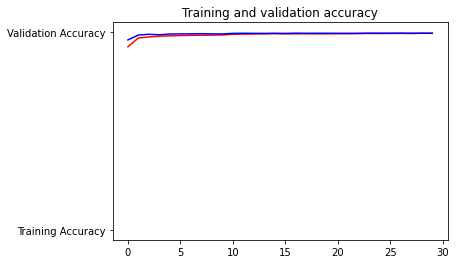

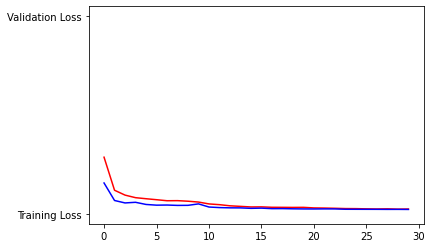

<Figure size 432x288 with 0 Axes>

In [36]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()

In [42]:
y_test

array([6, 1, 1, ..., 6, 2, 1], dtype=uint8)

In [47]:
results = model.predict(X_test)
results = np.argmax(results,axis=1)
results

219/219 [==============================] - 1s 4ms/step


array([6, 1, 1, ..., 6, 2, 1], dtype=int64)

In [51]:
score = 0
for i in range(len(results)):
    if results[i] == y_test[i]:
        score+=1

print(f"Test accurayc: {(score*100)/7001}")

Test accurayc: 99.41436937580346


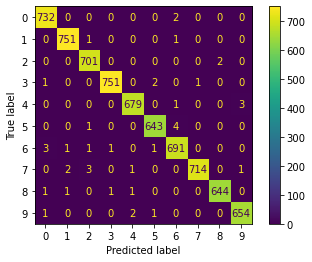

In [65]:
from sklearn import metrics

cnf_mat = metrics.confusion_matrix(y_test,results)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cnf_mat,display_labels=[0,1,2,3,4,5,6,7,8,9])

cm_display.plot()
plt.show()

### Saving Final Model

In [52]:
model.save("final_model.h5")

### Predicting a image

In [53]:
new_model = tf.keras.models.load_model('final_model.h5')
new_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 26, 26, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 64)       256       
 ormalization)                                                   
                                                                 
 activation_12 (Activation)  (None, 26, 26, 64)        0         
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 dropout_37 (Dropout)        (None, 13, 13, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 11, 11, 32)      

In [57]:
folder_path = "./Handwritten Digit/"

1/1 [==============================] - 0s 19ms/step
0
1/1 [==============================] - 0s 13ms/step
1
1/1 [==============================] - 0s 13ms/step
2
1/1 [==============================] - 0s 14ms/step
3
1/1 [==============================] - 0s 13ms/step
4
1/1 [==============================] - 0s 13ms/step
5
1/1 [==============================] - 0s 14ms/step
6
1/1 [==============================] - 0s 13ms/step
7
1/1 [==============================] - 0s 13ms/step
8
1/1 [==============================] - 0s 13ms/step
7


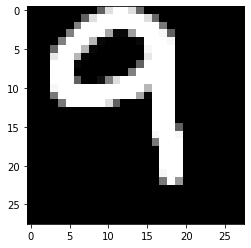

In [62]:
import os
import cv2

for image in os.listdir(folder_path):
    image_path = os.path.join(folder_path,image)
    pred_image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)

    plt.imshow(pred_image,cmap='gray')

    pred_img_resize = cv2.resize(pred_image,(28,28))
    pred_img_resize = cv2.bitwise_not(pred_img_resize)
    plt.imshow(pred_img_resize,cmap="gray")

    pred_img_normalized = pred_img_resize.astype('float32')/255.0
    pred_img_normalized = pred_img_normalized.reshape(1,28,28,1)
    result = new_model.predict(pred_img_normalized)
    print(np.argmax(result))